# -------------------------------OSCAR BEST PICTURE AWARD----------------------------------

Souri Rakhshanifar 

Student number: 1832728

# INTRODUCTION

In this notebook, I am focusing on predicting the chance of a movie winning "the best picture award" at the Oscars. 

The best picture award is awarded to the best movie of each year. For the first time, this title was awarded in 1927. The title changed the name in some years but the concept of the best movie was the same.  Typically each year, Oscars annonce a maximum of 7 to 8 nominees in this category and the winner will be selected among these movies. Therefore, the total number of winners in this category, since 1927, is about 70 and the number of nominees is about 520 movies. Looking into the mega database of movies (available on Kaggle. com), except for some exceptions of movies from the 1930s, most of these movies received an IMDb rating over 7.8 as well. However, the total number of movies achieving this rating is huge. 

Given all the above facts, I decided to compare nominated movies in this category (over the years), with the movies with similar IMDb ratings to differentiate nominees and their characteristics. This will help to predict the chance of a movie winning an award in this category. I didn't directly use the winners because the number of winners is so low and of course, the winner can be one out of the few movies that are nominated. With this, we improve the prediction to a more certain number. 

Worth to mention that there would be more features contributing to the final decision for the winner and many of them are unknown. However, many believe that worldwide political approaches are affecting this decision. Therefore, for further studies and to predict the actual winner, using data regarding the top events of each year is suggested. 

# DATA COLLECTION

In this project, I decided to scrape data regarding movies (both nominees and others) from IMDb database. I used advanced search from IMDb to find movies. The advanced search features that I used were:

. start year: 1927

. end year: 2023

. title groups=best picture nominees (for Oscar nominees)

. user rating= 7.8 to 10 (for others) 

URLs and details of scraping for both nominees and others are coming next.

P.S. Earlier I used movie database and IMDb APIs from rapidapi.com but unfortunately, none of the outputs was unnestable. That was the reason I couldn't manage to submit my notebook in the last block and then switch to web scraping.

But before moving to scraping part, I defined three functions for scraping multiple pages and to have the list and details of movies. The functions are:

The search results would be more than one page. So, I need a function to get the url of each page. 

Therefore, First function is to get a list of urls. 

In [57]:
from bs4 import BeautifulSoup # Beautifulsoup is the library I used for webscraping
def get_all_page(url_search,limit_page):
  url_list=[]
  c=1
  while url_search !='empty':
    c+=1
    url_list.append(url_search)
    Bsoup = BeautifulSoup(requests.get(url_search).text,"html.parser") 
    next_page = Bsoup.find_all(class_='lister-page-next next-page')
    if(len(next_page)>0):
      next_page_final = "https://www.imdb.com" + next_page[0].get('href')
      url_search=next_page_final     
    else: 
      url_search='empty'
    if(c>limit_page):
      break
  return url_list

Second function looks into the url list and scrape items (movie urls) and append them in a new list as the movie-list-page

In [58]:
import requests 
from tqdm import tqdm # I used tqdm module that adds a progress bar for iterating over a loop
def get_all_movies(url_search,limit_page):
  movies_list_page = [] 
  all_page_exist=get_all_page(url_search,limit_page)
  for page_link in tqdm(all_page_exist):     
    Bsoup = BeautifulSoup(requests.get(page_link).text, 'html.parser')
    movies_page = Bsoup.find_all("div",{"class" : "lister-item mode-advanced"}) 
    for one_movies in movies_page: 
      movies_list_page.append(one_movies)
  return movies_list_page

Third function scraps urls and gets the detail of movies

In [59]:
import pandas as pd
import numpy as np
from tqdm import tqdm
def get_info_movies(movies_list_page):
  all_info_movies=[]
  for item_movie_table in tqdm(movies_list_page):
    name_movie = item_movie_table.h3.a.text
    year_str = item_movie_table.h3.find('span', class_ = 'lister-item-year text-muted unbold')
    year_movie_num = pd.to_numeric(year_str.text.replace('(','').replace(')','').replace('I','').replace('–','')[0:4]) # I did that because the years came with () and I need them as a number and not as string

    if  (item_movie_table.find('strong')is not None):
      rating_movie = float(item_movie_table.strong.text)
    else:
      rating_movie=np.nan

    if item_movie_table.find('span', class_ = 'runtime') is not None:
      duration_movie = item_movie_table.find('span', class_ = 'runtime').text
    else:
      duration_movie = np.nan

    if item_movie_table.find('span', class_ = 'genre') is not None:
      genre_movie = item_movie_table.find('span', class_ = 'genre').text.strip()
    else:
      genre_movie = np.nan

    if item_movie_table.find('span', class_ = 'metascore favorable') is not None:
        metascore = item_movie_table.find('span', class_ = 'metascore favorable').text
    else:
        metascore  = 0

    item_votes_gross = item_movie_table.find_all('span',{"name":"nv"})
    if(len(item_votes_gross)==2):
        Votes=item_votes_gross[0].text
        Gross =item_votes_gross[1].text
    elif(len(item_votes_gross)==1):
        Votes=item_votes_gross[0].text
        Gross = np.nan
    else:
      Votes= np.nan
      Gross = np.nan 

    info_one_movie = [name_movie, year_movie_num, rating_movie, duration_movie, genre_movie,metascore,Votes, Gross]
    all_info_movies.append(info_one_movie)
  return all_info_movies

# SCRAPING DETAILS FOR NOMINEES

start_year='1927'
end_year='2023'
limit_page=6 # The numbers of nominees are around 530 items and since number of items per page is set as 100, limit page is 6
text_unique='oscar_best_picture_nominees'
cols_name=['name', 'year', 'rating', 'duration', 'genre','metascore','votes','gross']


url_search = 'https://www.imdb.com/search/title/?release_date='+start_year + ',' + end_year + \
                                          '&groups='+text_unique+'&sort=year,asc&count=100'

movies_list_page=get_all_movies(url_search,limit_page)
all_info_movies=get_info_movies(movies_list_page)
data_main_oscar=pd.DataFrame(all_info_movies,columns=cols_name)

In [61]:
data_oscar=data_main_oscar
data_oscar['label']='nominated' # I added a column as label to identify nominees later when I merge df for other movies to current df
data_oscar

,name,year,rating,duration,genre,metascore,votes,gross,label
0,Sunrise: A Song of Two Humans,1927,8.1,94 min,"Drama, Romance",95,"52,070",$0.54M,nominated
1,Wings,1927,7.6,144 min,"Drama, Romance, War",0,"13,560",$6.59M,nominated
2,7th Heaven,1927,7.6,110 min,"Drama, Romance",0,"3,838",$3.92M,nominated
3,Chang: A Drama of the Wilderness,1927,6.9,69 min,"Documentary, Adventure, Drama",0,"1,037",$0.61M,nominated
4,The Crowd,1928,8.1,98 min,"Drama, Music, Romance",0,"8,712",NaN,nominated
...,...,...,...,...,...,...,...,...,...
589,Top Gun: Maverick,2022,8.3,130 min,"Action, Drama",78,"560,296",$718.73M,nominated
590,Tár,2022,7.5,158 min,"Drama, Music",92,"64,554",NaN,nominated
591,The Fabelmans,2022,7.6,151 min,Drama,84,"80,536",NaN,nominated
592,Elvis,2022,7.3,159 min,"Biography, Drama, Music",64,"201,407",$151.04M,nominated


# SCRAPING NOT NOMINEES (but above 7.8 IMDb rating)

in this step, I limited the number of pages to 24 (50 items per page), because the total number of movies with a rating over 7.8 are huge. So, I decided to randomly choose 1200 of these movies for all the years as my sample. 

I didn't limit my search to recent movies or higher ratings because, at the end, many of the nominees are from earlier years or ahieved lower ratings (but still over 7.8) and I wanted to have a good distribution of my data among all different years. 

In [62]:
limit_page=24
text_unique='user_rating=7.8'
cols_name=['name', 'year', 'rating', 'duration', 'genre','metascore','votes','gross']
url_search = 'https://www.imdb.com/search/title/?user_rating=7.8,'
movies_list_page=get_all_movies(url_search,limit_page)
all_info_movies=get_info_movies(movies_list_page)
data_main_non_oscar=pd.DataFrame(all_info_movies,columns=cols_name)

100%|█████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:02<00:00, 537.24it/s]


In [63]:
data_main_non_oscar

,name,year,rating,duration,genre,metascore,votes,gross
0,John Wick: Chapter 4,2023,8.3,169 min,"Action, Crime, Thriller",78,"78,014",NaN
1,The Last of Us,2023,8.9,50 min,"Action, Adventure, Drama",0,"357,455",NaN
2,The Mandalorian,2019,8.7,40 min,"Action, Adventure, Fantasy",0,"521,770",NaN
3,Everything Everywhere All at Once,2022,7.9,139 min,"Action, Adventure, Comedy",81,"412,020",$72.86M
4,Ted Lasso,2020,8.8,30 min,"Comedy, Drama, Sport",0,"241,913",NaN
...,...,...,...,...,...,...,...,...
1195,Little Women,2022,7.8,75 min,"Action, Drama, Mystery",0,"4,956",NaN
1196,The Great British Baking Show,2010,8.6,60 min,"Game-Show, Reality-TV",0,"11,352",NaN
1197,The Manchurian Candidate,1962,7.9,126 min,"Drama, Thriller",94,"76,956",NaN
1198,Tumbbad,2018,8.2,104 min,"Drama, Fantasy, Horror",0,"51,916",NaN


Note that some of the 1200 movies are in our nominee list as well. To remove the duplication, I merge two dfs in a way that keeps just those rows that are not in both df

In [64]:
data_non_oscar=pd.merge(data_main_non_oscar,data_main_oscar, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
data_non_oscar

,name,year,rating,duration,genre,metascore,votes,gross,label
0,John Wick: Chapter 4,2023,8.3,169 min,"Action, Crime, Thriller",78,"78,014",NaN,NaN
1,The Last of Us,2023,8.9,50 min,"Action, Adventure, Drama",0,"357,455",NaN,NaN
2,The Mandalorian,2019,8.7,40 min,"Action, Adventure, Fantasy",0,"521,770",NaN,NaN
4,Ted Lasso,2020,8.8,30 min,"Comedy, Drama, Sport",0,"241,913",NaN,NaN
5,Daisy Jones & The Six,2023,8.1,49 min,"Drama, Music, Romance",0,"14,829",NaN,NaN
...,...,...,...,...,...,...,...,...,...
1195,Little Women,2022,7.8,75 min,"Action, Drama, Mystery",0,"4,956",NaN,NaN
1196,The Great British Baking Show,2010,8.6,60 min,"Game-Show, Reality-TV",0,"11,352",NaN,NaN
1197,The Manchurian Candidate,1962,7.9,126 min,"Drama, Thriller",94,"76,956",NaN,NaN
1198,Tumbbad,2018,8.2,104 min,"Drama, Fantasy, Horror",0,"51,916",NaN,NaN


In [65]:
data_non_oscar['label']='others'
data_non_oscar

,name,year,rating,duration,genre,metascore,votes,gross,label
0,John Wick: Chapter 4,2023,8.3,169 min,"Action, Crime, Thriller",78,"78,014",NaN,others
1,The Last of Us,2023,8.9,50 min,"Action, Adventure, Drama",0,"357,455",NaN,others
2,The Mandalorian,2019,8.7,40 min,"Action, Adventure, Fantasy",0,"521,770",NaN,others
4,Ted Lasso,2020,8.8,30 min,"Comedy, Drama, Sport",0,"241,913",NaN,others
5,Daisy Jones & The Six,2023,8.1,49 min,"Drama, Music, Romance",0,"14,829",NaN,others
...,...,...,...,...,...,...,...,...,...
1195,Little Women,2022,7.8,75 min,"Action, Drama, Mystery",0,"4,956",NaN,others
1196,The Great British Baking Show,2010,8.6,60 min,"Game-Show, Reality-TV",0,"11,352",NaN,others
1197,The Manchurian Candidate,1962,7.9,126 min,"Drama, Thriller",94,"76,956",NaN,others
1198,Tumbbad,2018,8.2,104 min,"Drama, Fantasy, Horror",0,"51,916",NaN,others


# MERGING DFs (NOMINEES AND OTHERS)

In [66]:
data_final=pd.concat([data_oscar,data_non_oscar])
data_final.reset_index(drop=True,inplace=True)
data_final

,name,year,rating,duration,genre,metascore,votes,gross,label
0,Sunrise: A Song of Two Humans,1927,8.1,94 min,"Drama, Romance",95,"52,070",$0.54M,nominated
1,Wings,1927,7.6,144 min,"Drama, Romance, War",0,"13,560",$6.59M,nominated
2,7th Heaven,1927,7.6,110 min,"Drama, Romance",0,"3,838",$3.92M,nominated
3,Chang: A Drama of the Wilderness,1927,6.9,69 min,"Documentary, Adventure, Drama",0,"1,037",$0.61M,nominated
4,The Crowd,1928,8.1,98 min,"Drama, Music, Romance",0,"8,712",NaN,nominated
...,...,...,...,...,...,...,...,...,...
1621,Little Women,2022,7.8,75 min,"Action, Drama, Mystery",0,"4,956",NaN,others
1622,The Great British Baking Show,2010,8.6,60 min,"Game-Show, Reality-TV",0,"11,352",NaN,others
1623,The Manchurian Candidate,1962,7.9,126 min,"Drama, Thriller",94,"76,956",NaN,others
1624,Tumbbad,2018,8.2,104 min,"Drama, Fantasy, Horror",0,"51,916",NaN,others


This is our final df (1622 rows including 594 nominated movies and 1028 others). This looks like a reasonable sample.

# DATA CLEANING


looking to our final df, columns genre, vote, gross, duration and rating should be cleaned:
    
genre: fillna, str to list
    
votes: remove "," , type=float, mean
    
gross: remove $ and change M to number
    
duration: type=float, mean
    
rating: type=float, mean

# GENRE

In [67]:
data_final['genre']=data_final['genre'].fillna('Empty')
data_final.genre=data_final.genre.str.split(',')
data_final['genre']=data_final['genre'].apply(lambda x: [ item.strip() for item in x])
data_final['genre']

0                      [Drama, Romance]
1                 [Drama, Romance, War]
2                      [Drama, Romance]
3       [Documentary, Adventure, Drama]
4               [Drama, Music, Romance]
                     ...               
1621           [Action, Drama, Mystery]
1622            [Game-Show, Reality-TV]
1623                  [Drama, Thriller]
1624           [Drama, Fantasy, Horror]
1625                            [Drama]
Name: genre, Length: 1626, dtype: object

# VOTES

In [68]:
data_final['votes']=data_final['votes'].apply(lambda x: str(x).replace(',',''))
data_final=data_final.replace('nan',np.nan)
data_final['votes']=data_final['votes'].astype(float)
data_final['votes']=data_final['votes'].fillna(data_final['rating'].mean())

# GROSS

In [69]:
data_final['gross']=data_final['gross'].apply(lambda x: str(x).replace('M','').replace('$',''))
data_final=data_final.replace('nan',np.nan)
data_final['gross']=data_final['gross'].astype(float)
data_final['gross']=data_final['gross'].fillna(data_final['gross'].mean())

#          DURATION

In [70]:
data_final['duration']=data_final['duration'].apply(lambda x: str(x).replace('min',''))
data_final=data_final.replace('nan',np.nan)
data_final['duration']=data_final['duration'].astype(float)
data_final['duration']=data_final['duration'].fillna(data_final['duration'].mean())

# RATING

In [71]:
data_final['rating']=data_final['rating'].astype(float)
data_final['rating']=data_final['rating'].fillna(data_final['rating'].mean())

In [72]:
data_final

,name,year,rating,duration,genre,metascore,votes,gross,label
0,Sunrise: A Song of Two Humans,1927,8.1,94.0,"[Drama, Romance]",95,52070.0,0.540000,nominated
1,Wings,1927,7.6,144.0,"[Drama, Romance, War]",0,13560.0,6.590000,nominated
2,7th Heaven,1927,7.6,110.0,"[Drama, Romance]",0,3838.0,3.920000,nominated
3,Chang: A Drama of the Wilderness,1927,6.9,69.0,"[Documentary, Adventure, Drama]",0,1037.0,0.610000,nominated
4,The Crowd,1928,8.1,98.0,"[Drama, Music, Romance]",0,8712.0,82.688785,nominated
...,...,...,...,...,...,...,...,...,...
1621,Little Women,2022,7.8,75.0,"[Action, Drama, Mystery]",0,4956.0,82.688785,others
1622,The Great British Baking Show,2010,8.6,60.0,"[Game-Show, Reality-TV]",0,11352.0,82.688785,others
1623,The Manchurian Candidate,1962,7.9,126.0,"[Drama, Thriller]",94,76956.0,82.688785,others
1624,Tumbbad,2018,8.2,104.0,"[Drama, Fantasy, Horror]",0,51916.0,82.688785,others


# ONE HOT ENCODING

We need all data in numerical format. therefore, to convert categorical order to numerical data. In one hot encoding, each category is represented as a binary vector where all values are zero, except for the index corresponding to the category, which is set to one.

In [73]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(sparse_output=True)
data_final_pre=data_final.join(pd.DataFrame.sparse.from_spmatrix(mlb.fit_transform(data_final['genre']),
                                                             index=data_final.index,
                                                             columns=mlb.classes_))
data_final_pre.drop(['genre','name'],axis=1, inplace=True)
data_final_pre

,year,rating,duration,metascore,votes,gross,label,Action,Adventure,Animation,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,1927,8.1,94.0,95,52070.0,0.540000,nominated,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1927,7.6,144.0,0,13560.0,6.590000,nominated,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,1927,7.6,110.0,0,3838.0,3.920000,nominated,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1927,6.9,69.0,0,1037.0,0.610000,nominated,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1928,8.1,98.0,0,8712.0,82.688785,nominated,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1621,2022,7.8,75.0,0,4956.0,82.688785,others,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1622,2010,8.6,60.0,0,11352.0,82.688785,others,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1623,1962,7.9,126.0,94,76956.0,82.688785,others,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1624,2018,8.2,104.0,0,51916.0,82.688785,others,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# LABELS: 1 FOR NOMINEES AND 0 FOR OTHERS

In [74]:
data_final_pre['label']=data_final_pre['label'].apply(lambda x: 1 if x=='nominated' else 0 )
data_final_pre

,year,rating,duration,metascore,votes,gross,label,Action,Adventure,Animation,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,1927,8.1,94.0,95,52070.0,0.540000,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1927,7.6,144.0,0,13560.0,6.590000,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,1927,7.6,110.0,0,3838.0,3.920000,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1927,6.9,69.0,0,1037.0,0.610000,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1928,8.1,98.0,0,8712.0,82.688785,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1621,2022,7.8,75.0,0,4956.0,82.688785,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1622,2010,8.6,60.0,0,11352.0,82.688785,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1623,1962,7.9,126.0,94,76956.0,82.688785,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1624,2018,8.2,104.0,0,51916.0,82.688785,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
data_final_pre=data_final_pre.astype(float)

# VISUALIZATION

# CORRELATIONS

To see the correlations between all columns, heatmap is used. 
Red and Blue colors has been selected so we can easily distinguish the positive and negetive numbers.
in here, the most important column to consider is label.

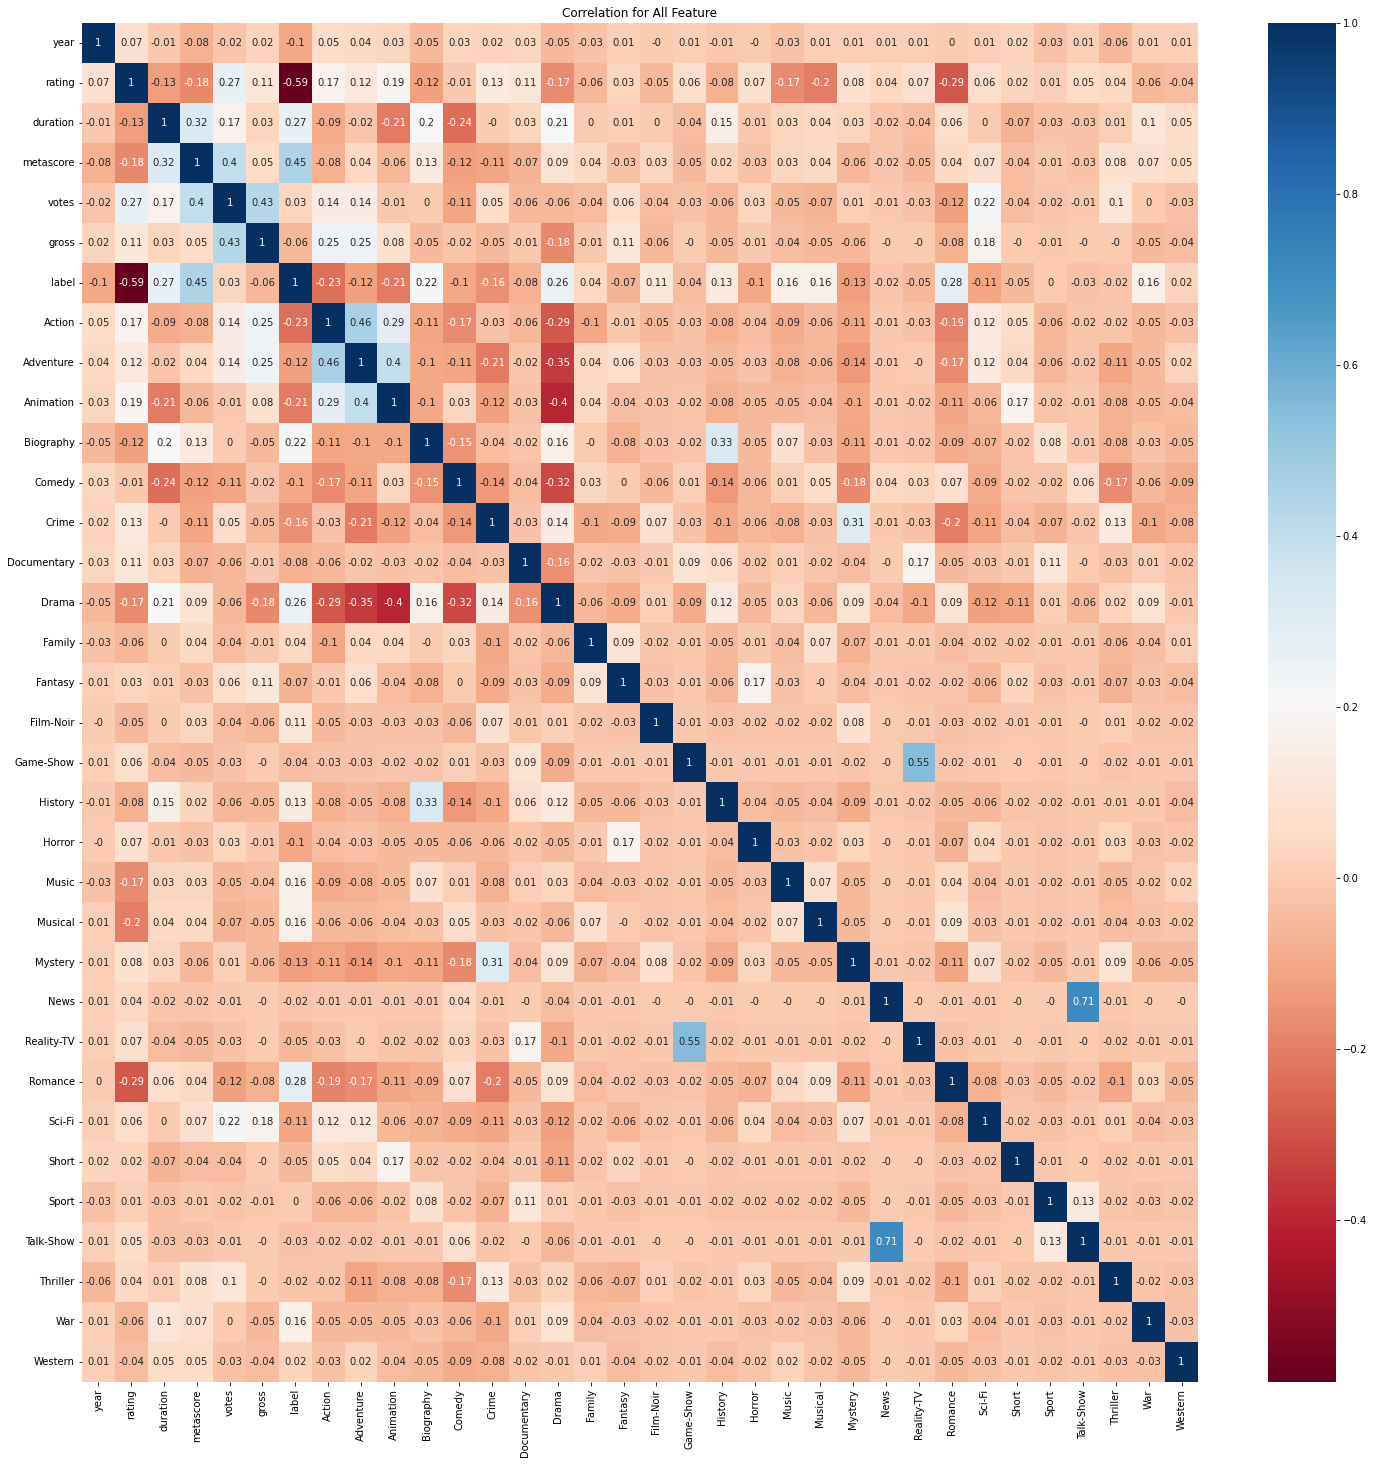

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(25,25))
cor = np.round(data_final_pre.corr(),2)
sns.heatmap(cor, annot=True, cmap=plt.cm.RdBu)
plt.title("Correlation for All Feature",fontsize=12)
plt.show()

As we see, the column lable (nominated or not) is more corelated with column regarding ganer, metascore and duration

# PIE AND BAR CHARTS

First pie chart shows the distribution of the data in general (nominated to others or 1 to zeros)

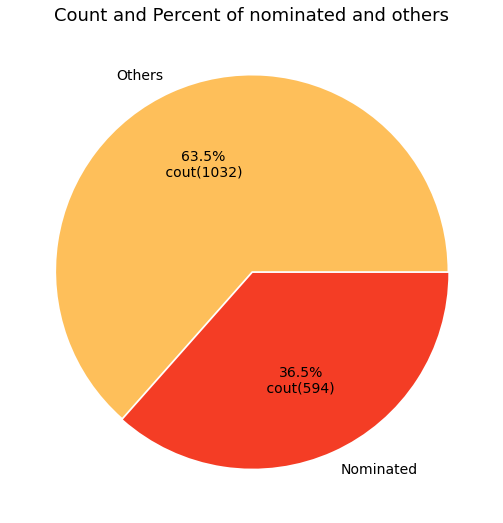

In [77]:
import matplotlib.pyplot as plot
import seaborn as sns
title_txt='Count and Percent of nominated and others'
y_label=''
x_label=''
item_color='YlOrRd'

data_plot=pd.DataFrame()
data_plot['index_name']=data_final_pre.groupby(by='label').size().index
data_plot['count_val']=data_final_pre.groupby(by='label').size().values

def fmt(x):
    return '{:.1f}%\n cout({:.0f}) '.format(x, data_plot['count_val'].sum()*x/100)

pat_color = sns.color_palette(item_color, len(data_plot))

plt.figure(figsize=(9,9))
explode=[0,0.01]
plt.pie(data_plot['count_val'], 
          labels=['Others','Nominated'], 
          colors=pat_color,
          autopct=fmt,
          explode=explode, textprops={'fontsize': 14})
plt.title(title_txt,fontsize=18)
plt.show()

Second graph compares the duration of the movies (nominated and others)

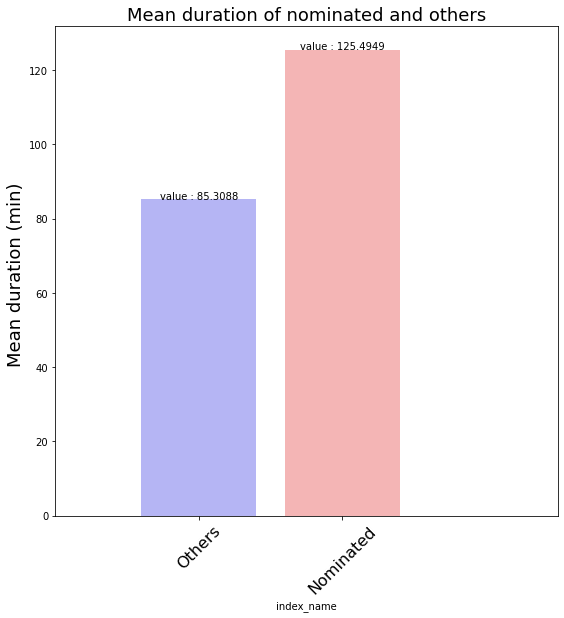

In [78]:
import matplotlib.pyplot as plot
import seaborn as sns
title_txt='Mean duration of nominated and others'
y_label='Mean duration (min) '
x_label=''
item_color='bwr'

data_plot=pd.DataFrame()
data_plot['index_name']=data_final_pre.groupby(by='label')['duration'].mean().index
data_plot['count_val']=data_final_pre.groupby(by='label')['duration'].mean().values

def fmt(x):
    return '{:.1f}% '.format(x)

pat_color = sns.color_palette(item_color, len(data_plot))

plt.figure(figsize=(9,9))
explode=[0,0.01]
g=sns.barplot(data=data_plot,x='index_name', y='count_val',palette=pat_color,)
plt.xticks([0,1],['Others','Nominated'],rotation=45,fontsize=16)
for index, row in data_plot.iterrows():
  txt_value='value : '+str(np.round(row.count_val,4))
  g.text(row.name, row.count_val, txt_value, color='black', ha="center",rotation=0)
plt.title(title_txt,fontsize=18)
plt.ylabel(y_label,fontsize=18)
plt.xlim([-1,2.5])
plt.show()

This figure shows that the nominated movies are significantly longer than non nominated movies (others)

Next bar chart shows the ratings of nominees and others

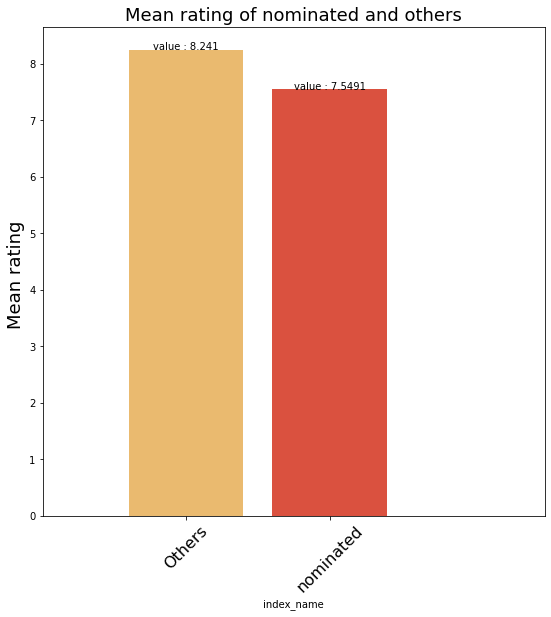

In [79]:
import matplotlib.pyplot as plot
import seaborn as sns
title_txt='Mean rating of nominated and others'
y_label='Mean rating '
x_label=''
item_color='YlOrRd'

data_plot=pd.DataFrame()
data_plot['index_name']=data_final_pre.groupby(by='label')['rating'].mean().index
data_plot['count_val']=data_final_pre.groupby(by='label')['rating'].mean().values

def fmt(x):
    return '{:.1f}% '.format(x)

pat_color = sns.color_palette(item_color, len(data_plot))

plt.figure(figsize=(9,9))
explode=[0,0.01]
g=sns.barplot(data=data_plot,x='index_name', y='count_val',palette=pat_color,)
plt.xticks([0,1],['Others','nominated'],rotation=45,fontsize=16)
for index, row in data_plot.iterrows():
  txt_value='value : '+str(np.round(row.count_val,4))
  g.text(row.name, row.count_val, txt_value, color='black', ha="center",rotation=0)
plt.title(title_txt,fontsize=18)
plt.ylabel(y_label,fontsize=18)
plt.xlim([-1,2.5])
plt.show()

Also, this bar chart shows a significant distance between mean ratings of the movies (nominated and others)

Forth graph compares meta score of the movies

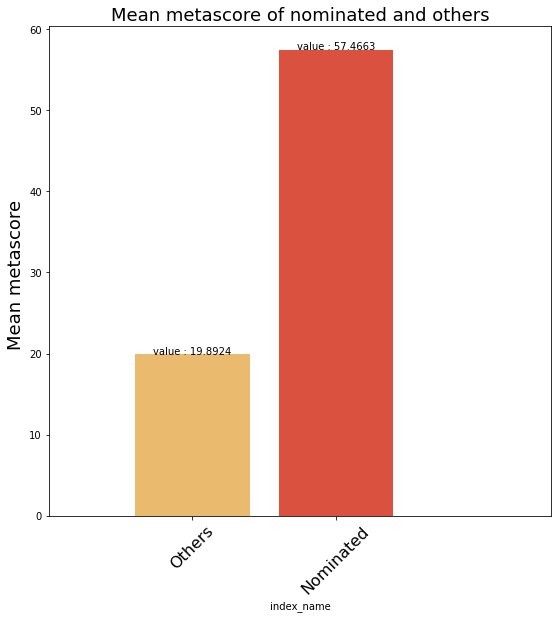

In [80]:
import matplotlib.pyplot as plot
import seaborn as sns
title_txt='Mean metascore of nominated and others'
y_label='Mean metascore '
x_label=''
item_color='YlOrRd'

data_plot=pd.DataFrame()
data_plot['index_name']=data_final_pre.groupby(by='label')['metascore'].mean().index
data_plot['count_val']=data_final_pre.groupby(by='label')['metascore'].mean().values

def fmt(x):
    return '{:.1f}% '.format(x)

pat_color = sns.color_palette(item_color, len(data_plot))

plt.figure(figsize=(9,9))
explode=[0,0.01]
g=sns.barplot(data=data_plot,x='index_name', y='count_val',palette=pat_color,)
plt.xticks([0,1],['Others','Nominated'],rotation=45,fontsize=16)
for index, row in data_plot.iterrows():
  txt_value='value : '+str(np.round(row.count_val,4))
  g.text(row.name, row.count_val, txt_value, color='black', ha="center",rotation=0)
plt.title(title_txt,fontsize=18)
plt.ylabel(y_label,fontsize=18)
plt.xlim([-1,2.5])
plt.show()

The distance is more visible here

# GENERAL DISTRIBUTION

In [ ]:
import matplotlib.pyplot as plot
import seaborn as sns
title_txt='Number of sample in each year'
y_label='Number of sample '
x_label=''
item_color='YlOrRd'

data_plot=pd.DataFrame()
data_plot['year']=data_final_pre.groupby(by='year').size().index
data_plot['count_val']=data_final_pre.groupby(by='year').size().values

def fmt(x):
    return '{:.1f}% '.format(x)

pat_color = sns.color_palette(item_color, len(data_plot))

plt.figure(figsize=(12,12))
explode=[0,0.01]
g=sns.barplot(data=data_plot,x='year', y='count_val',palette=pat_color,)

idx=range(0,data_plot.shape[0],3)
plt.xticks(idx,data_plot.iloc[idx,0],rotation=90)

plt.title(title_txt,fontsize=18)
plt.ylabel(y_label,fontsize=18)
plt.show()

Obviously, with the growth of the movie industry, the total number of produced movies are more than those in 1930's . Therefore, the above chart (our sample) represesnts an acceptible distribution of data over years.

# SCATTER DIAGRAMS

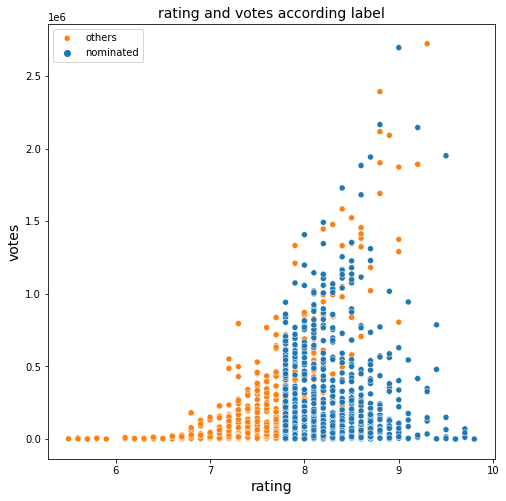

In [82]:
import matplotlib.pyplot as plot
import seaborn as sns
plt.figure(figsize=(8,8))
sns.scatterplot(data=data_final_pre,x="rating",y="votes",hue="label")
plt.legend(['others','nominated'])
plt.title('rating and votes according label',fontsize=14)
plt.ylabel("votes",fontsize=14)
plt.xlabel("rating",fontsize=14)
plt.show()

above chart shows that nominated movies recieved higher ratings (never less than 7.8) while non of others went higher than 9.2.

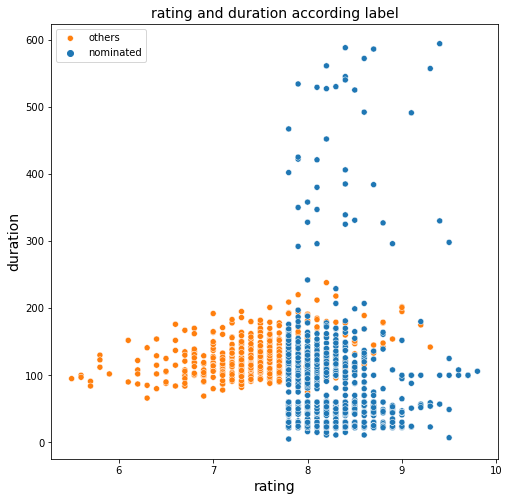

In [83]:
import matplotlib.pyplot as plot
import seaborn as sns
plt.figure(figsize=(8,8))
sns.scatterplot(data=data_final_pre,x="rating",y="duration",hue="label")
plt.legend(['others','nominated'])
plt.title('rating and duration according label',fontsize=14)
plt.ylabel("duration",fontsize=14)
plt.xlabel("rating",fontsize=14)
plt.show()

although the mean of the duration for nominated movies is higher than others the median is lower. the reason for that is many outliers with the duration over 400 mins in nominated movies.

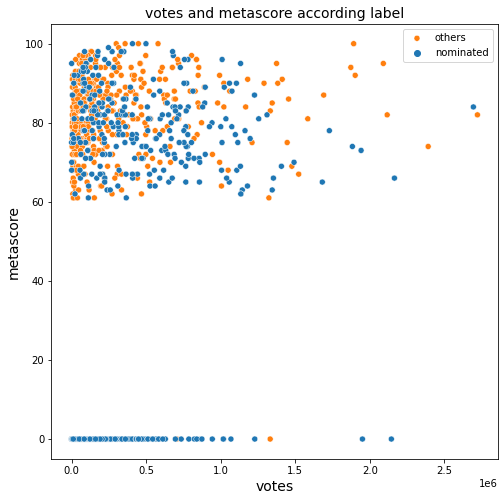

In [84]:
import matplotlib.pyplot as plot
import seaborn as sns
plt.figure(figsize=(8,8))
sns.scatterplot(data=data_final_pre,x="votes",y="metascore",hue="label")
plt.legend(['others','nominated'])
plt.title('votes and metascore according label',fontsize=14)
plt.ylabel("metascore",fontsize=14)
plt.xlabel("votes",fontsize=14)
plt.show()

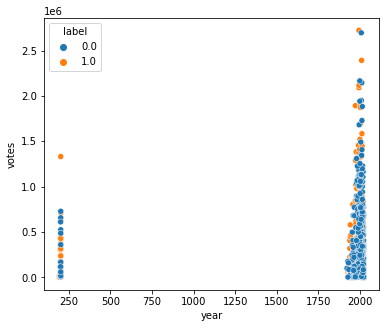

In [85]:
import matplotlib.pyplot as plot
import seaborn as sns
plt.figure(figsize=(6,5))
sns.scatterplot(data=data_final_pre,x="year",y="votes",hue="label")
plt.show()

# TRAIN AND TEST

# NORMALIZATION

In [86]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(data_final_pre)
scaled_base = scaler.transform(data_final_pre)
data_scaled = pd.DataFrame(scaled_base, index=data_final_pre.index, columns=data_final_pre.columns)
data_scaled

C:\Users\souri\anaconda3\lib\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\souri\anaconda3\lib\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


,year,rating,duration,metascore,votes,gross,label,Action,Adventure,Animation,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,0.947541,0.604651,0.151104,0.95,0.019126,0.000577,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.947541,0.488372,0.235993,0.00,0.004979,0.007036,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.947541,0.488372,0.178268,0.00,0.001407,0.004185,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.947541,0.325581,0.108659,0.00,0.000378,0.000651,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.948087,0.604651,0.157895,0.00,0.003198,0.088280,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1621,0.999454,0.534884,0.118846,0.00,0.001818,0.088280,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1622,0.992896,0.720930,0.093379,0.00,0.004167,0.088280,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1623,0.966667,0.558140,0.205433,0.94,0.028269,0.088280,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1624,0.997268,0.627907,0.168081,0.00,0.019070,0.088280,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# SPLIT DATA TO TRAIN AND TEST DATA

In [99]:
data_ready=data_scaled.loc[:,data_scaled.columns!='label'].values
lbl_ready=data_scaled.loc[:,data_scaled.columns=='label'].values

In [100]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_ready ,
                                                    lbl_ready ,
                                                    test_size=0.20,
                                                    shuffle=True,
                                                    random_state=42)


print('_'*50)
print('X_train shape: {}'.format(X_train.shape))
print('X_test shape:  {}'.format(X_test.shape))
print('_'*50)

__________________________________________________
X_train shape: (1300, 33)
X_test shape:  (326, 33)
__________________________________________________


# MACHINE LEARNING

In here, I used 5 classic machine learning models (KNN, Linear Regression, Decision Tree, MLP and SVC) and compare their performance usign different matrics. Performance Metrics that I used are: 

Accuracy: The proportion of correctly classified instances to the total number of instances in the dataset.

Precision: The proportion of true positives to the total number of positive predictions made by the model.

Recall: The proportion of true positives to the total number of actual positive instances in the dataset.

F1 Score: The harmonic mean of precision and recall, which provides a single metric that balances both metrics.

In [102]:
# pip install mlxtend 

In [103]:
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

# save all metrics
array_score=np.zeros((5,11))

In [104]:
import matplotlib.pyplot as plt

def perf_measure(y_actual, y_pred): 
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
        if y_actual[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_actual[i]!=y_pred[i]:
           FP += 1
        if y_actual[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_actual[i]!=y_pred[i]:
           FN += 1

    return(TP, FP, TN, FN)

def plt_confusion_matrix(lbl_real,lbl_pred,algorithm_name):
  Con_matrix=confusion_matrix(lbl_real,lbl_pred)
  fig, ax = plot_confusion_matrix(conf_mat=Con_matrix,
                                  show_absolute=True,
                                  show_normed=True,
                                  colorbar=True)
      
  ax.set_title('outconfusion_matrix:'+ algorithm_name)


# KNN

K-Nearest Neighbors (KNN) is a classification model that shows the predicted value of a target variable based on the k number of nearest data points in the training sets.

---------------------KNN---------------------


C:\Users\souri\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


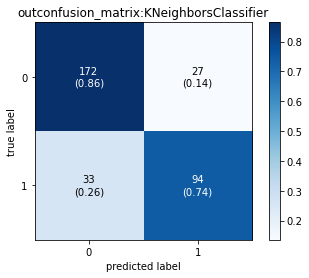

In [105]:
from sklearn.neighbors import KNeighborsClassifier
print('---------------------KNN---------------------')
K=0;
classifier = KNeighborsClassifier (n_neighbors=13)
classifier.fit(X_train, y_train)
Test_predict= classifier.predict(X_test)
classfi_report=classification_report(y_test, Test_predict,output_dict=True)
# save to array
array_score[K,1]=accuracy_score(y_test, Test_predict)
array_score[K,2]= classfi_report['macro avg']['precision'] 
array_score[K,3]= classfi_report['macro avg']['recall']    
array_score[K,4]= classfi_report['macro avg']['f1-score']
TN, FP, FN, TP = perf_measure(y_test, Test_predict)
FPR =round( FP/(FP+TN),4)
FNR =np.round( FN/(TP+FN),4)
array_score[K,5]=TN
array_score[K,6]=FP
array_score[K,7]=FN
array_score[K,8]=TP
array_score[K,9]=FPR
array_score[K,10]=FNR
plt_confusion_matrix(y_test,Test_predict,'KNeighborsClassifier')

In [106]:
print(classifier.n_features_in_)

33


33 is the number of features in the input data used to fit the classifier

# LINEAR REGRESSION

Linear regression is a statistical method used to find the best-fit line that describes the relationship between the variables. 

---------------------LogisticRegression---------------------


C:\Users\souri\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


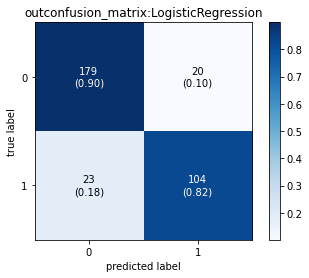

In [107]:
from sklearn.linear_model import LogisticRegression

print('---------------------LogisticRegression---------------------')
K=1;
classifier = LogisticRegression(random_state=100,C=10)
classifier.fit(X_train, y_train)
Test_predict= classifier.predict(X_test)
classfi_report=classification_report(y_test, Test_predict,output_dict=True)
# save to array
array_score[K,1]=accuracy_score(y_test, Test_predict)
array_score[K,2]= classfi_report['macro avg']['precision'] 
array_score[K,3]= classfi_report['macro avg']['recall']    
array_score[K,4]= classfi_report['macro avg']['f1-score']
TN, FP, FN, TP = perf_measure(y_test, Test_predict)
FPR =round( FP/(FP+TN),4)
FNR =np.round( FN/(TP+FN),4)
array_score[K,5]=TN
array_score[K,6]=FP
array_score[K,7]=FN
array_score[K,8]=TP
array_score[K,9]=FPR
array_score[K,10]=FNR
plt_confusion_matrix(y_test,Test_predict,'LogisticRegression')

# DECISION TREE

A decision tree is a tree-like structure where each internal node represents a test on an attribute, each branch represents the outcome of the test, and each leaf node represents a class label or a numerical value.

---------------------DT---------------------


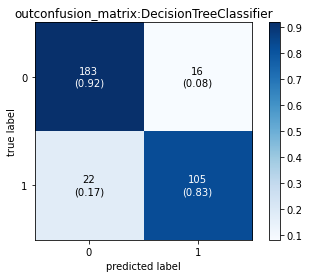

In [108]:
from sklearn.tree import DecisionTreeClassifier
print('---------------------DT---------------------')
K=2;
classifier = DecisionTreeClassifier(random_state=1,max_depth=30,min_samples_split=4)
classifier.fit(X_train, y_train)
Test_predict= classifier.predict(X_test)
classfi_report=classification_report(y_test, Test_predict,output_dict=True)
# save to array
array_score[K,1]=accuracy_score(y_test, Test_predict)
array_score[K,2]= classfi_report['macro avg']['precision'] 
array_score[K,3]= classfi_report['macro avg']['recall']    
array_score[K,4]= classfi_report['macro avg']['f1-score']
TN, FP, FN, TP = perf_measure(y_test, Test_predict)
FPR =round( FP/(FP+TN),4)
FNR =np.round( FN/(TP+FN),4)
array_score[K,5]=TN
array_score[K,6]=FP
array_score[K,7]=FN
array_score[K,8]=TP
array_score[K,9]=FPR
array_score[K,10]=FNR
plt_confusion_matrix(y_test,Test_predict,'DecisionTreeClassifier')

# MLP

Multi-Layer Perceptron (MLP) consists of multiple layers of interconnected nodes called neurons. The number of hidden layers and neurons per layer is a hyperparameter that needs to be tuned to optimize the model's performance.


---------------------mlp---------------------


C:\Users\souri\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


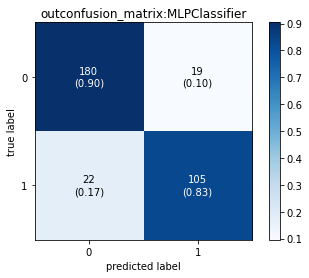

In [109]:
from sklearn.neural_network import MLPClassifier

print('---------------------mlp---------------------')
K=3;
classifier = MLPClassifier(solver='adam',
                           random_state=1044,
                           hidden_layer_sizes=[512], 
                           max_iter=10000)
classifier.fit(X_train, y_train)
Test_predict= classifier.predict(X_test)
classfi_report=classification_report(y_test, Test_predict,output_dict=True)
# save to array
array_score[K,1]=accuracy_score(y_test, Test_predict)
array_score[K,2]= classfi_report['macro avg']['precision'] 
array_score[K,3]= classfi_report['macro avg']['recall']    
array_score[K,4]= classfi_report['macro avg']['f1-score']
TN, FP, FN, TP = perf_measure(y_test, Test_predict)
FPR =round( FP/(FP+TN),4)
FNR =np.round( FN/(TP+FN),4)
array_score[K,5]=TN
array_score[K,6]=FP
array_score[K,7]=FN
array_score[K,8]=TP
array_score[K,9]=FPR
array_score[K,10]=FNR
plt_confusion_matrix(y_test,Test_predict,'MLPClassifier')

# SVC

Support Vector Machine Classifier (SVC) aims to learn a hyperplane that can effectively separate the data into different classes by maximizing the margin between the closest data points from different classes.

C:\Users\souri\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


---------------------SVM---------------------


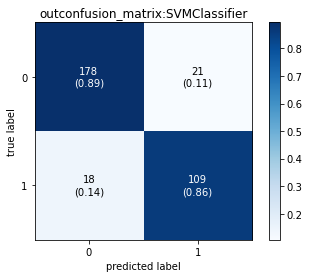

In [110]:
from sklearn.svm import SVC

print('---------------------SVM---------------------')
K=4;
classifier = SVC(gamma='scale',C=10,)
classifier.fit(X_train, y_train)
Test_predict= classifier.predict(X_test)
classfi_report=classification_report(y_test, Test_predict,output_dict=True)
# save to array
array_score[K,1]=accuracy_score(y_test, Test_predict)
array_score[K,2]= classfi_report['macro avg']['precision'] 
array_score[K,3]= classfi_report['macro avg']['recall']    
array_score[K,4]= classfi_report['macro avg']['f1-score']
TN, FP, FN, TP = perf_measure(y_test, Test_predict)
FPR =round( FP/(FP+TN),4)
FNR =np.round( FN/(TP+FN),4)
array_score[K,5]=TN
array_score[K,6]=FP
array_score[K,7]=FN
array_score[K,8]=TP
array_score[K,9]=FPR
array_score[K,10]=FNR
plt_confusion_matrix(y_test,Test_predict,'SVMClassifier')

# RESULTS

In [111]:
data_res_clf=pd.DataFrame(np.round(array_score,3),columns=["algorithm","accuracy","precision","recall","f1-score" ,
                                                   "TP","FP","FN","TP","FPR","FNR"])
data_res_clf["algorithm"]=["KNN","LR","DT","MLP","SVM"]
data_res_clf

,algorithm,accuracy,precision,recall,f1-score,TP,FP,FN,TP,FPR,FNR
0,KNN,0.816,0.808,0.802,0.805,94.0,27.0,172.0,33.0,0.223,0.839
1,LR,0.868,0.862,0.859,0.861,104.0,20.0,179.0,23.0,0.161,0.886
2,DT,0.883,0.880,0.873,0.876,105.0,16.0,183.0,22.0,0.132,0.893
3,MLP,0.874,0.869,0.866,0.867,105.0,19.0,180.0,22.0,0.153,0.891
4,SVM,0.880,0.873,0.876,0.875,109.0,21.0,178.0,18.0,0.162,0.908


Different methods'performance is different in terms of different performance metrics. For exapmle, DT shows higher accuracy however SVM perform better in predicting positives as we see the recall is highr in this method. The choice of the best method depends on the type of the data. For example, in a diagnostice task, the cost of a false negative (missing a disease) may be much higher than the cost of a false positive (incorrectly diagnosing a disease), so the sensitivity (true positive rate) may be a more important metric than the overall accuracy. In our case:

Precision measures the proportion of true positive predictions (correctly predicting a movie that actually got nominated) among all positive predictions. A high precision indicates that the model is accurate in its positive predictions, which is important for avoiding false positives.

Recall measures the proportion of true positive predictions among all actual positive instances. A high recall indicates that the model is able to identify most of the positive instances (all movies that actually got nominated) , which is important for avoiding false negatives.

F1-score is the harmonic mean of precision and recall, which provides a balanced measure of both metrics. A high F1-score indicates that the model is both accurate and able to identify most of the positive instances.

Accuracy measures the overall proportion of correct predictions (the number of correctly predicted nominees divided by the total number of movies). If the dataset was imbalance (which is not the case in here), accuracy could not be a useful performance measure because even the models that always predict positive or negative could get a high accuracy rate. 

# COMPARISON

<Figure size 720x720 with 0 Axes>

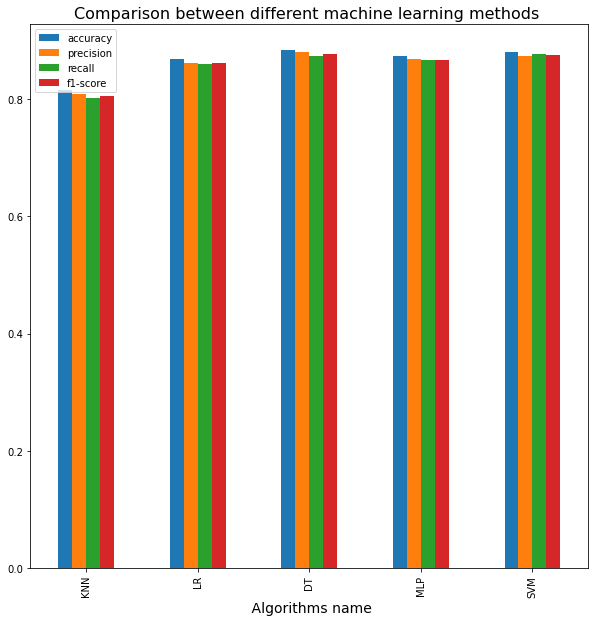

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10,10))
data_res_clf.plot(x="algorithm",
                     y=data_res_clf.columns[1:5],
                     kind="bar",figsize=(10,10)).legend(loc='upper left')
plt.title('Comparison between different machine learning methods ',fontsize=16)
plt.xlabel(' Algorithms name',fontsize=14)
plt.savefig("out.png",dpi=300)
plt.show()

Above figure is a better representation of the results. 

As we can see, However the predictions using different methods perform almost in a same range the decision tree model shows the highest accuracy, precision and F1-score in comparison to other traditional machin learning models. 

KNN is performing not good compared to other models. It can be due to imbalanced class distribution with one class being much more prevalent than the other (it has been represented and justified in the provided graphs earlier).


Further studies could combine movie metadata with top events of each year and see if it can improve the results.